In [ ]:
pip install transformers torch scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 22.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd


In [ ]:
df = pd.read_csv('train.csv')



In [ ]:
df.head()

,Id,Tweet,following,followers,actions,is_retweet,location,Type
0,10091,It's the everything else that's complicated. #...,0.0,11500.0,NaN,0.0,Chicago,Quality
1,10172,Eren sent a glare towards Mikasa then nodded a...,0.0,0.0,NaN,0.0,NaN,Quality
2,7012,I posted a new photo to Facebook http://fb.me/...,0.0,0.0,NaN,0.0,"Scotland, U.K",Quality
3,3697,#jan Idiot Chelsea Handler Diagnoses Trump Wit...,3319.0,611.0,294.0,0.0,"Atlanta, Ga",Spam
4,10740,Pedophile Anthony Weiner is TERRIFIED of Getti...,4840.0,1724.0,1522.0,0.0,Blumberg,Spam


In [ ]:
columns_to_delete = ['Id', 'followers','following','actions','is_retweet','location']
df.drop(columns=columns_to_delete, inplace=True)

In [ ]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Tokenization
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
tokenized_texts = [tokenizer.encode(text, add_special_tokens=True) for text in df['Tweet']]


In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# Padding and Truncating
MAX_LEN = 30
input_ids = torch.tensor(pad_sequences(tokenized_texts, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post"))


In [ ]:
labels = torch.tensor(df['Type'].map({'Spam': 1, 'Quality': 0}).values)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_ids, labels, test_size=0.2, random_state=42)


In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training
batch_size = 32
train_data = TensorDataset(X_train, y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=1e-5)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
model.to(device)
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

In [ ]:
# Train the model
model.train()
epochs = 2  # Adjust as needed

for epoch in range(epochs):
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [ ]:
# Evaluation
model.eval()
with torch.no_grad():
    predictions = []
    for batch in X_test:
        outputs = model(batch.unsqueeze(0))
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1)
        predictions.append(predicted_class.item())

    y_pred = torch.tensor(predictions)

accuracy = accuracy_score(y_test.cpu(), y_pred.cpu())
report = classification_report(y_test.cpu(), y_pred.cpu())

print(f"Accuracy: {accuracy}")
print(report)

Accuracy: 0.949874686716792
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1198
           1       0.93      0.97      0.95      1196

    accuracy                           0.95      2394
   macro avg       0.95      0.95      0.95      2394
weighted avg       0.95      0.95      0.95      2394



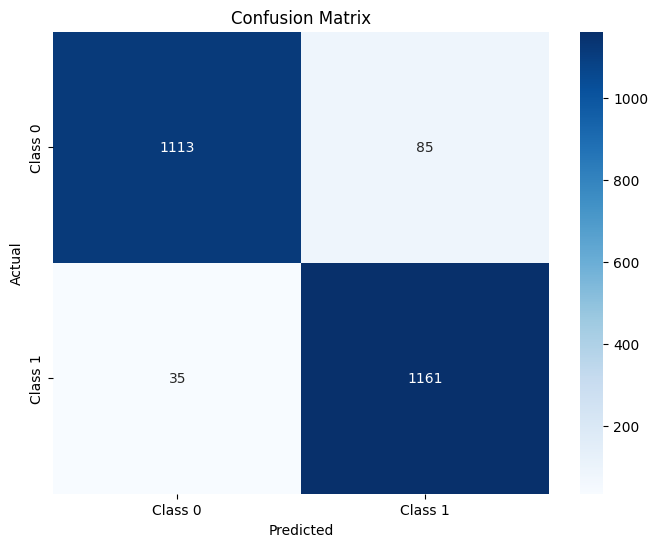

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
confusion = confusion_matrix(y_test.cpu(), y_pred.cpu())

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()